Combine data into one place

In [10]:
import pandas as pd
import glob
import os

In [ ]:


def merge_csv_files(folder_path, output_file="merged.csv"):
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df.columns = [col.strip() for col in df.columns]
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)

# Use correct relative path for CICIDS2017 folder
merge_csv_files("../../CICIDS2017", "merged.csv")

Create two datasets, one is raw, the other is processed

In [2]:
import pandas as pd
import numpy as np

# ==== SETTINGS ====
file_path = "merged.csv"
fraction = 0.15  # % of data

# ==== 1. Load in chunks to avoid memory blowups ====
chunks = []
chunk_size = 10_000  # adjust based on RAM
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # 2. Downcast to reduce memory usage
    for col in chunk.select_dtypes(include=['int', 'float']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')
    
    chunks.append(chunk)

data = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ==== 3. Homogeneous sampling ====
data = data.sample(frac=fraction, random_state=42)

# ==== 4. Convert all numeric to float32 for PyTorch ====
for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col] = data[col].astype(np.float32)

# ==== Final check ====
print(f"Final shape: {data.shape}")
print(data.dtypes.head())

Final shape: (424611, 79)
Destination Port               float32
Flow Duration                  float32
Total Fwd Packets              float32
Total Backward Packets         float32
Total Length of Fwd Packets    float32
dtype: object


LSTM Model

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
)
import optuna

# ==============================
# 1. Prepare data
# ==============================
data_numeric = data.select_dtypes(include=[np.number]).copy()

X = data_numeric.drop(columns=["Label"]).values
y = data_numeric["Label"].values.astype(int)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM: (samples, timesteps, features)
# Here we treat each row as one timestep sequence of length 1
X = X.reshape(X.shape[0], 1, X.shape[1])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# 2. Define LSTM Model
# ==============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = self.fc(out)
        return self.sigmoid(out)

# ==============================
# 3. Optuna Objective
# ==============================
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = LSTMModel(X.shape[2], hidden_dim, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.float32)),
                            batch_size=batch_size, shuffle=False)

    # Training
    model.train()
    for epoch in range(5):  # keep short for tuning
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    y_probs = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            y_probs.extend(preds.flatten())

    y_val_pred = np.array(y_probs)
    pr_auc = average_precision_score(y_val, y_val_pred)

    return pr_auc

# ==============================
# 4. Run Optuna Study
# ==============================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:", study.best_trial.params)

# ==============================
# 5. Retrain best model on train+val
# ==============================
best_params = study.best_trial.params
best_model = LSTMModel(X.shape[2], best_params["hidden_dim"],
                       best_params["num_layers"], best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
criterion = nn.BCELoss()

trainval_loader = DataLoader(TensorDataset(torch.tensor(np.concatenate([X_train, X_val]), dtype=torch.float32),
                                           torch.tensor(np.concatenate([y_train, y_val]), dtype=torch.float32)),
                             batch_size=best_params["batch_size"], shuffle=True)

for epoch in range(15):  # longer training
    best_model.train()
    for xb, yb in trainval_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = best_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

# ==============================
# 6. Test Evaluation with threshold selection
# ==============================
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)),
                         batch_size=128, shuffle=False)

best_model.eval()
y_probs = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = best_model(xb).cpu().numpy()
        y_probs.extend(preds.flatten())
y_probs = np.array(y_probs)

# Pick best threshold by F1
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]

y_pred = (y_probs >= best_thresh).astype(int)

print("Test AUROC:", roc_auc_score(y_test, y_probs))
print("Test PR AUC:", average_precision_score(y_test, y_probs))
print("Best Threshold:", best_thresh)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


KeyError: "['Label'] not found in axis"

In [2]:
import torch
import sys
print("Python executable:", sys.executable)
print("Torch location:", torch.__file__)
print("Torch version:", torch.__version__)


Python executable: c:\Users\gokde\anaconda3\envs\torch_gpu\python.exe
Torch location: c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\torch\__init__.py
Torch version: 2.5.1+cu121


In [19]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# ==============================
# 1. Prepare data
# ==============================
# Assume 'data' is your sampled DataFrame
data_numeric = data.select_dtypes(include=[np.number]).astype(np.float32)
data_numeric = data_numeric.replace([np.inf, -np.inf], np.nan).fillna(0.0)
data_numeric = data_numeric.clip(-1e6, 1e6)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Suppose you have a 'Label' column in original data
labels = np.where(data['Label'] == 'BENIGN', 0, 1).astype(np.float32)

# ==============================
# 2. Create sequences
# ==============================
def create_seq(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])  # predict next timestep
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

seq_length = 20
X_seq, y_seq = create_seq(data_scaled, labels, seq_length)

# ==============================
# 3. DataLoader
# ==============================
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_seq), torch.tensor(y_seq))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ==============================
# 4. LSTM Model
# ==============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # single output for binary

    def forward(self, x, h0=None, c0=None):
        batch_size = x.size(0)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn

input_dim = X_seq.shape[2]
hidden_dim = 128
layer_dim = 1

model = LSTMModel(input_dim, hidden_dim, layer_dim)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model.to(device)

# ==============================
# 5. Loss + optimizer
# ==============================
num_positives = np.sum(y_seq)            # count anomalies
num_negatives = len(y_seq) - num_positives
pos_weight = torch.tensor(num_negatives / num_positives, dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ==============================
# 6. Training loop
# ==============================
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits, _ = model(batch_X)
        loss = criterion(logits, batch_Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
        
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == batch_Y).sum().item()
        total += batch_X.size(0)
    
    avg_loss = total_loss / len(train_loader.dataset)
    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, Accuracy: {acc:.4f}")

# ==============================
# 7. Evaluation
# ==============================
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_seq).to(device)
    logits, hidden = model(X_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()
    predictions = (probs > 0.5).astype(int)

# Metrics
cm = confusion_matrix(y_seq, predictions)
precision = precision_score(y_seq, predictions, zero_division=0)
recall = recall_score(y_seq, predictions, zero_division=0)
f1 = f1_score(y_seq, predictions, zero_division=0)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Optional: use last hidden state as suspicion score
suspicion_scores = np.linalg.norm(hidden[-1].cpu().numpy(), axis=1)
print("Suspicion scores (first 10):", suspicion_scores[:10])


Using device: cuda


KeyboardInterrupt: 

# CELLS AFTER THIS ARE TEMP

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def evaluate_anomalies(pred, y_true_seq, original_df, label_col="Label", top_pct=5):
    """
    Evaluate LSTM predictions against CICIDS2017 labels.

    Parameters:
        pred: np.ndarray, predicted next-step values [num_samples, num_features]
        y_true_seq: np.ndarray, true next-step values [num_samples, num_features]
        original_df: pd.DataFrame, original DataFrame including 'Label'
        label_col: str, name of column with BENIGN/anomaly labels
        top_pct: float, percentile of suspicion scores to label anomalies

    Returns:
        dict with MSE, confusion matrix, precision, recall, F1, anomalies detected
    """
    # 1. Compute suspicion scores (L2 norm per sample)
    suspicion_scores = np.linalg.norm(pred - y_true_seq, axis=1)

    # 2. Determine threshold
    threshold = np.percentile(suspicion_scores, 100 - top_pct)

    # 3. Predicted anomaly labels (1 = anomaly, 0 = benign)
    y_pred = (suspicion_scores > threshold).astype(int)

    # 4. Ground truth anomaly labels (1 = anomaly, 0 = BENIGN)
    # Align y_true_seq with original_df
    start_idx = original_df.shape[0] - y_true_seq.shape[0]  # account for sequence offset
    y_true_labels = original_df[label_col].iloc[start_idx:].apply(lambda x: 0 if x == "BENIGN" else 1).to_numpy()

    # 5. Compute metrics
    mse = ((pred - y_true_seq) ** 2).mean()
    cm = confusion_matrix(y_true_labels, y_pred)
    precision = precision_score(y_true_labels, y_pred)
    recall = recall_score(y_true_labels, y_pred)
    f1 = f1_score(y_true_labels, y_pred)

    results = {
        "MSE": mse,
        "ConfusionMatrix": cm,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "SuspicionScores": suspicion_scores,
        "PredictedAnomalies": y_pred
    }

    print(f"Mean Squared Error: {mse:.6f}")
    print("Confusion Matrix:\n", cm)
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    print(f"Number of anomalies detected: {y_pred.sum()} / {len(y_pred)}")

    return results


results = evaluate_anomalies(
    pred=pred.numpy(),
    y_true_seq=y_seq,
    original_df=data,
    label_col="Label",
    top_pct=5
)


NameError: name 'pred' is not defined

In [ ]:
import torch
import torch.nn.functional as F

def evaluate_model(model, X, y_true, threshold=0.5, device='cpu'):
    """
    Evaluate a trained LSTM model on sequences.
    
    Args:
        model      : trained LSTM model
        X          : input tensor, shape [num_samples, seq_length, num_features]
        y_true     : true labels tensor, shape [num_samples, 1]
        threshold  : threshold to consider anomaly (for binary classification)
        device     : 'cpu' or 'cuda'
    
    Returns:
        metrics dict: contains loss, accuracy, predictions, suspicion scores
    """
    model.eval()
    X, y_true = X.to(device), y_true.to(device)
    
    with torch.no_grad():
        y_pred, _, _ = model(X)  # output shape: [num_samples, 1]
        
        # Loss
        loss_fn = torch.nn.MSELoss()
        loss = loss_fn(y_pred, y_true).item()
        
        # Convert predictions to binary labels
        y_pred_labels = (y_pred >= threshold).float()
        
        # Accuracy
        correct = (y_pred_labels == y_true).sum().item()
        total = y_true.size(0)
        accuracy = correct / total
        
        # Suspicion score: predicted probability of anomaly
        suspicion_scores = y_pred.squeeze().cpu().numpy()
        
    return {
        "loss": loss,
        "accuracy": accuracy,
        "y_pred_labels": y_pred_labels.cpu().numpy(),
        "suspicion_scores": suspicion_scores
    }

# Example usage
metrics = evaluate_model(model, trainX, trainY)
print("Loss:", metrics["loss"])
print("Accuracy:", metrics["accuracy"])
print("Suspicion scores (first 10):", metrics["suspicion_scores"][:10])


#CELLS AFTER THIS ARE PROGRESS

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import optuna

# ==============================
# 1. Prepare data
# ==============================
# Assuming 'data' is already the 5% sampled DataFrame from merged.csv
data_numeric = data.select_dtypes(include=[np.number]).copy()
data_numeric = data_numeric.replace([np.inf, -np.inf], np.nan).fillna(0.0)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_numeric)

labels = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).to_numpy()
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

def create_seq(X, y, seq_length=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_length = 50
X_seq, y_seq = create_seq(X_scaled, labels, seq_length)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)

# Train/validation split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

# ==============================
# 2. Dataset + DataLoader
# ==============================
def make_loader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# ==============================
# 3. Define LSTM
# ==============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, layer_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        last_hidden = out[:, -1, :]
        logit = self.fc(last_hidden)
        return logit, last_hidden

# ==============================
# 4. Training & Evaluation
# ==============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def train_and_eval(hidden_dim=32, layer_dim=1, lr=1e-3, batch_size=64, epochs=10):
    train_loader = make_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_loader = make_loader(X_val, y_val, batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_dim=X_seq.shape[2], hidden_dim=hidden_dim, layer_dim=layer_dim).to(device)
    num_neg, num_pos = np.sum(y_train == 0), np.sum(y_train == 1)
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- Training loop ---
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device, dtype=torch.float32).unsqueeze(1)
            optimizer.zero_grad()
            logits, _ = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(logits)
            total_loss += loss.item() * batch_X.size(0)
            total_correct += ((probs > 0.5) == batch_y).sum().item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.6f}, "
              f"Accuracy: {total_correct/len(train_loader.dataset):.4f}")

    # --- Validation evaluation ---
    model.eval()
    all_probs, all_preds, all_hidden = [], [], []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            logits, last_hidden = model(batch_X)
            probs = torch.sigmoid(logits).cpu()
            preds = (probs > 0.5).int()
            all_probs.append(probs)
            all_preds.append(preds)
            all_hidden.append(last_hidden.cpu())

    all_probs = torch.cat(all_probs).numpy().flatten()
    all_preds = torch.cat(all_preds).numpy().flatten()
    all_hidden = torch.cat(all_hidden).numpy()
    suspicion_scores = np.linalg.norm(all_hidden, axis=1)

    cm = confusion_matrix(y_val, all_preds)
    prec = precision_score(y_val, all_preds, zero_division=0)
    rec = recall_score(y_val, all_preds, zero_division=0)
    f1 = f1_score(y_val, all_preds, zero_division=0)
    auroc = roc_auc_score(y_val, all_probs)
    pr_auc = average_precision_score(y_val, all_probs)

    print("Confusion Matrix:\n", cm)
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}, PR-AUC: {pr_auc:.4f}")
    print("Suspicion scores (first 10):", suspicion_scores[:10])

    return pr_auc  # use PR-AUC for hyperparameter optimization

# ==============================
# 5. Baseline sanity checks
# ==============================
y_majority = np.zeros_like(y_val)
y_random = np.random.randint(0, 2, size=len(y_val))

print("\n--- Baseline: Majority class ---")
print("Acc:", (y_majority == y_val).mean(), "F1:", f1_score(y_val, y_majority, zero_division=0))

print("\n--- Baseline: Random guessing ---")
print("Acc:", (y_random == y_val).mean(), "F1:", f1_score(y_val, y_random, zero_division=0))

# ==============================
# 6. Bayesian optimization with Optuna
# ==============================
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    layer_dim = trial.suggest_int("layer_dim", 1, 3)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    return train_and_eval(hidden_dim=hidden_dim, layer_dim=layer_dim, lr=lr,
                          batch_size=batch_size, epochs=5)  # fewer epochs for tuning

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # try 10 configs

print("\nBest hyperparameters:", study.best_params)


Class distribution: {np.int64(0): np.int64(340905), np.int64(1): np.int64(83706)}
X_seq shape: (424561, 50, 78) y_seq shape: (424561,)
Using device: cuda

--- Baseline: Majority class ---


[I 2025-08-18 00:33:23,376] A new study created in memory with name: no-name-0dc5f4c2-2bad-4068-9c0e-5388ae857d24


Acc: 0.802751051075807 F1: 0.0

--- Baseline: Random guessing ---
Acc: 0.5000294418993558 F1: 0.28207122805830825


C:\Users\gokde\AppData\Local\Temp\ipykernel_13664\484083997.py:151: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[W 2025-08-18 00:33:28,730] Trial 0 failed with parameters: {'hidden_dim': 64, 'layer_dim': 2, 'lr': 0.00013007416807320993, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_13664\484083997.py", line 153, in objective
    return train_and_eval(hidden_dim=hidden_dim, layer_dim=layer_dim, lr=lr,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import optuna

# ==============================
# 1. Prepare data
# ==============================
data_numeric = data.select_dtypes(include=[np.number]).copy()
data_numeric = data_numeric.replace([np.inf, -np.inf], np.nan).fillna(0.0)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_numeric)

labels = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1).to_numpy()
unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

def create_seq(X, y, seq_length=50):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_length = 50
X_seq, y_seq = create_seq(X_scaled, labels, seq_length)
print("X_seq shape:", X_seq.shape, "y_seq shape:", y_seq.shape)

# Train/validation split
split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


# ==============================
# 2. Dataset + DataLoader
# ==============================
def make_loader(X, y, batch_size=64, shuffle=True):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# ==============================
# 3. Define LSTM
# ==============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, layer_dim=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        last_hidden = out[:, -1, :]
        logit = self.fc(last_hidden)
        return logit, last_hidden

# ==============================
# 4. Training function (used in Optuna)
# ==============================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def train_and_eval(hidden_dim=32, layer_dim=1, lr=1e-3, batch_size=64, epochs=10, dropout=0.0):
    train_loader = make_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_loader = make_loader(X_val, y_val, batch_size=batch_size, shuffle=False)

    model = LSTMModel(input_dim=X_seq.shape[2], hidden_dim=hidden_dim, layer_dim=layer_dim, dropout=dropout).to(device)
    num_neg, num_pos = np.sum(y_train == 0), np.sum(y_train == 1)
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # --- Training loop ---
    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device, dtype=torch.float32).unsqueeze(1)
            optimizer.zero_grad()
            logits, _ = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(logits)
            total_loss += loss.item() * batch_X.size(0)
            total_correct += ((probs > 0.5) == batch_y).sum().item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset):.6f}, "
              f"Accuracy: {total_correct/len(train_loader.dataset):.4f}")

    # --- Validation evaluation ---
    model.eval()
    all_probs = []
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            logits, _ = model(batch_X)
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
    all_probs = torch.cat(all_probs).numpy().flatten()

    pr_auc = average_precision_score(y_val, all_probs)
    return pr_auc, model, all_probs  # return probs for threshold tuning

# ==============================
# 5. Baseline sanity checks
# ==============================
y_majority = np.zeros_like(y_val)
y_random = np.random.randint(0, 2, size=len(y_val))

print("\n--- Baseline: Majority class ---")
print("Acc:", (y_majority == y_val).mean(), "F1:", f1_score(y_val, y_majority, zero_division=0))

print("\n--- Baseline: Random guessing ---")
print("Acc:", (y_random == y_val).mean(), "F1:", f1_score(y_val, y_random, zero_division=0))

# ==============================
# 6. Optuna optimization
# ==============================
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    layer_dim = trial.suggest_int("layer_dim", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    pr_auc, _, _ = train_and_eval(hidden_dim, layer_dim, lr, batch_size, epochs=5, dropout=dropout)
    return pr_auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("\nBest hyperparameters:", study.best_params)

# ==============================
# 7. Retrain best model on train+val
# ==============================
best_params = study.best_params
X_trainval = np.concatenate([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])

trainval_loader = make_loader(X_trainval, y_trainval, batch_size=best_params["batch_size"], shuffle=True)

best_model = LSTMModel(input_dim=X_seq.shape[2],
                       hidden_dim=best_params["hidden_dim"],
                       layer_dim=best_params["layer_dim"],
                       dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
num_neg, num_pos = np.sum(y_trainval == 0), np.sum(y_trainval == 1)
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(15):
    best_model.train()
    for batch_X, batch_y in trainval_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device, dtype=torch.float32).unsqueeze(1)
        optimizer.zero_grad()
        logits, _ = best_model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

# ==============================
# 8. Test evaluation + threshold tuning
# ==============================
test_loader = make_loader(X_val, y_val, batch_size=128, shuffle=False)  # replace with real test if available
best_model.eval()
all_probs = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        logits, _ = best_model(batch_X)
        probs = torch.sigmoid(logits).cpu()
        all_probs.append(probs)
all_probs = torch.cat(all_probs).numpy().flatten()

# Tune threshold based on F1
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_val, (all_probs >= t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
y_pred = (all_probs >= best_thresh).astype(int)

print("Best threshold:", best_thresh)
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("AUROC:", roc_auc_score(y_val, all_probs))
print("PR-AUC:", average_precision_score(y_val, all_probs))


Class distribution: {np.int64(0): np.int64(340905), np.int64(1): np.int64(83706)}


[I 2025-08-18 14:17:41,013] A new study created in memory with name: no-name-3597c1c1-3405-4a2a-9c30-49e59a5054bb


X_seq shape: (424561, 50, 78) y_seq shape: (424561,)
Using device: cuda

--- Baseline: Majority class ---
Acc: 0.802751051075807 F1: 0.0

--- Baseline: Random guessing ---
Acc: 0.5008655918410608 F1: 0.2837926897274279


[W 2025-08-18 14:18:12,859] Trial 0 failed with parameters: {'hidden_dim': 32, 'layer_dim': 2, 'lr': 0.005404325181626058, 'batch_size': 128, 'dropout': 0.019813085892406768} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_20960\3520822581.py", line 136, in objective
    pr_auc, _, _ = train_and_eval(hidden_dim, layer_dim, lr, batch_size, epochs=5, dropout=dropout)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gokde\AppData\Local\Temp\ipykernel_20960\3520822581.py", line 89, in train_and_eval
    logits, _ = model(batch_X)
                ^^^^^^^^^^^^^^
  File "c:\Users\gokde\anaconda3\envs\torch_gpu\Lib\site-packages\torch\nn\modules\module.p

KeyboardInterrupt: 

=== Data Analysis ===
Dataset shape: (424611, 79)

Label distribution:
Label
BENIGN                        340905
DoS Hulk                       34754
PortScan                       23826
DDoS                           19194
DoS GoldenEye                   1528
FTP-Patator                     1232
SSH-Patator                      878
DoS slowloris                    874
DoS Slowhttptest                 804
Bot                              291
Web Attack � Brute Force         226
Web Attack � XSS                  86
Web Attack � Sql Injection         7
Infiltration                       4
Heartbleed                         2
Name: count, dtype: int64

Unique labels: ['BENIGN' 'DoS Hulk' 'DDoS' 'PortScan' 'DoS slowloris' 'DoS GoldenEye'
 'FTP-Patator' 'DoS Slowhttptest' 'Bot' 'SSH-Patator'
 'Web Attack � Brute Force' 'Web Attack � XSS' 'Heartbleed'
 'Web Attack � Sql Injection' 'Infiltration']

Binary label distribution: {np.int64(0): np.int64(340905), np.int64(1): np.int64(83706)}
Attac

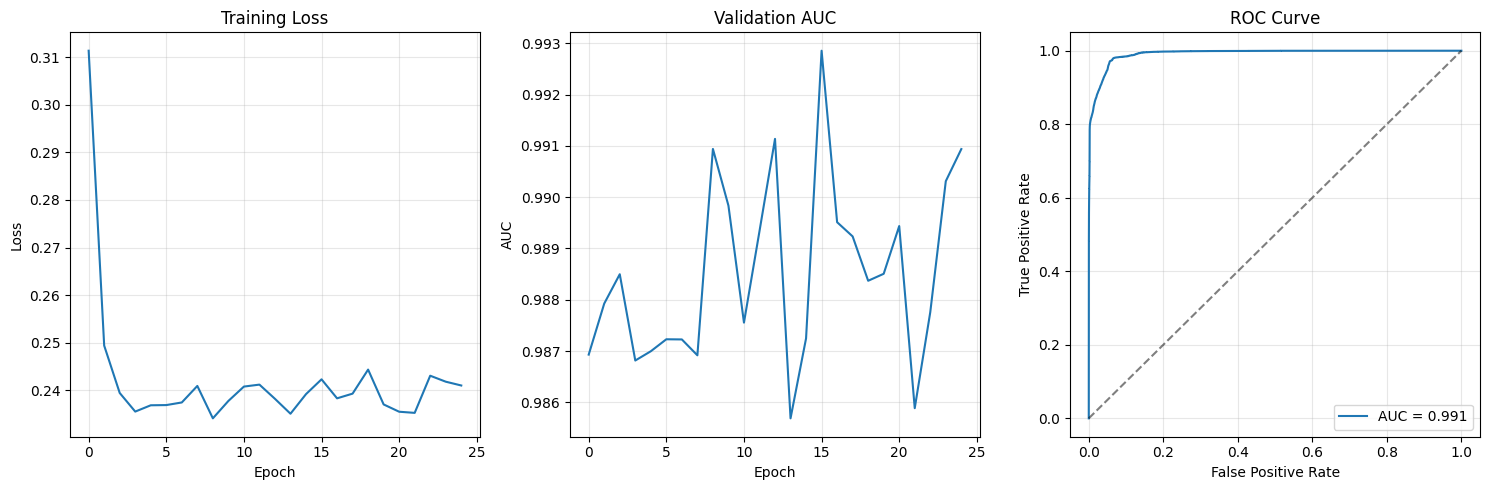

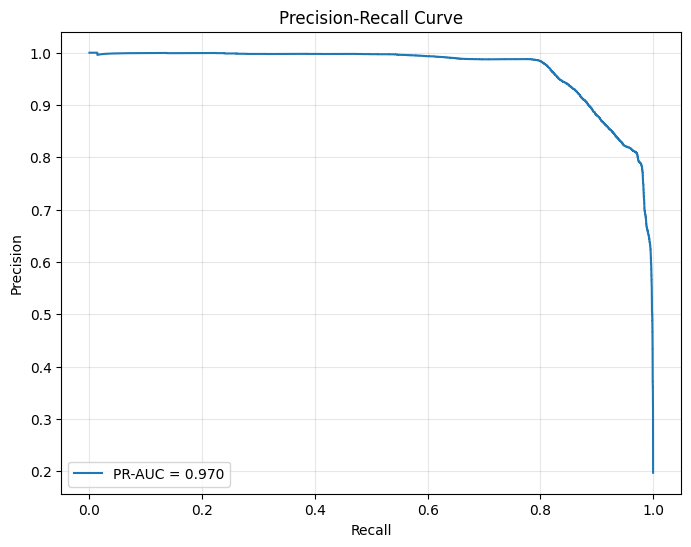


=== Analysis Complete ===
If AUC is still low (<0.7), consider:
1. Check if your labels are correct
2. Try different feature engineering
3. Use a different model architecture
4. Ensure your data has temporal structure suitable for LSTM


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
import optuna
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 1. Data Analysis and Preprocessing
# ==============================
print("=== Data Analysis ===")
print("Dataset shape:", data.shape)
print("\nLabel distribution:")
label_counts = data['Label'].value_counts()
print(label_counts)

# Check label types
unique_labels = data['Label'].unique()
print(f"\nUnique labels: {unique_labels}")

# Create binary labels - be more explicit about mapping
def create_binary_labels(labels):
    """Convert labels to binary (0=benign, 1=attack)"""
    binary_labels = []
    for label in labels:
        if isinstance(label, str):
            if label.upper() == 'BENIGN':
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        else:
            # If numeric, assume 0 is benign
            binary_labels.append(1 if label != 0 else 0)
    return np.array(binary_labels)

labels = create_binary_labels(data['Label'])
unique, counts = np.unique(labels, return_counts=True)
print(f"\nBinary label distribution: {dict(zip(unique, counts))}")
print(f"Attack ratio: {counts[1]/len(labels):.4f}")

# ==============================
# 2. Feature Engineering and Cleaning
# ==============================
print("\n=== Feature Engineering ===")

# Get numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in numeric_cols:
    numeric_cols.remove('Label')

print(f"Number of numeric features: {len(numeric_cols)}")

X = data[numeric_cols].copy()

# Check for problematic columns
print("\nChecking data quality...")
inf_counts = np.isinf(X).sum()
nan_counts = X.isnull().sum()
zero_var_cols = X.columns[X.var() == 0].tolist()

print(f"Columns with infinite values: {inf_counts[inf_counts > 0].shape[0]}")
print(f"Columns with NaN values: {nan_counts[nan_counts > 0].shape[0]}")
print(f"Zero variance columns: {len(zero_var_cols)}")

# Clean the data
# Replace infinite values with NaN first
X = X.replace([np.inf, -np.inf], np.nan)

# Remove columns with too many missing values (>50%)
missing_threshold = 0.5
high_missing_cols = X.columns[X.isnull().sum() / len(X) > missing_threshold].tolist()
if high_missing_cols:
    print(f"Removing columns with >{missing_threshold*100}% missing: {high_missing_cols}")
    X = X.drop(columns=high_missing_cols)

# Remove zero variance columns
if zero_var_cols:
    remaining_zero_var = [col for col in zero_var_cols if col in X.columns]
    if remaining_zero_var:
        print(f"Removing zero variance columns: {remaining_zero_var}")
        X = X.drop(columns=remaining_zero_var)

# Fill remaining missing values with median
X = X.fillna(X.median())

# Remove highly correlated features to reduce redundancy
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
if high_corr_cols:
    print(f"Removing {len(high_corr_cols)} highly correlated features")
    X = X.drop(columns=high_corr_cols)

print(f"Final feature count: {X.shape[1]}")

# ==============================
# 3. Scaling and Train-Test Split
# ==============================
print("\n=== Scaling and Splitting ===")

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Check if scaling worked
print(f"Scaled data range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")
print(f"Scaled data mean: {X_scaled.mean():.3f}, std: {X_scaled.std():.3f}")

# Split the data BEFORE creating sequences
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train samples: {len(X_train)} (attack rate: {y_train.mean():.4f})")
print(f"Val samples: {len(X_val)} (attack rate: {y_val.mean():.4f})")
print(f"Test samples: {len(X_test)} (attack rate: {y_test.mean():.4f})")

# ==============================
# 4. Baseline Model Check
# ==============================
print("\n=== Baseline Model Check ===")

# Test with a simple Random Forest to see if the data is learnable
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_prob = rf.predict_proba(X_val)[:, 1]

print(f"Random Forest - AUC: {roc_auc_score(y_val, rf_prob):.4f}")
print(f"Random Forest - F1: {f1_score(y_val, rf_pred):.4f}")

if roc_auc_score(y_val, rf_prob) < 0.6:
    print("WARNING: Even Random Forest performs poorly. Check your data and labels!")

# ==============================
# 5. Create Sequences for LSTM
# ==============================
def create_sliding_windows(X, y, window_size=5, step=1):
    """Create sliding windows for time series"""
    X_windows = []
    y_windows = []
    
    for i in range(0, len(X) - window_size + 1, step):
        X_windows.append(X[i:i + window_size])
        # Use the label of the last sample in the window
        y_windows.append(y[i + window_size - 1])
    
    return np.array(X_windows, dtype=np.float32), np.array(y_windows, dtype=np.float32)

# Create sequences for each split
window_size = 5  # Smaller window for faster training
print(f"\nCreating sequences with window size: {window_size}")

X_train_seq, y_train_seq = create_sliding_windows(X_train, y_train, window_size)
X_val_seq, y_val_seq = create_sliding_windows(X_val, y_val, window_size)
X_test_seq, y_test_seq = create_sliding_windows(X_test, y_test, window_size)

print(f"Train sequences: {X_train_seq.shape}")
print(f"Val sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")

# ==============================
# 6. Simple LSTM Model
# ==============================
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last time step
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        
        # Apply dropout and classify
        output = self.dropout(last_output)
        logits = self.classifier(output)
        
        return logits.squeeze(-1)

# ==============================
# 7. Training Function with Debugging
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

def train_lstm_model(X_train, y_train, X_val, y_val, 
                    hidden_dim=32, num_layers=1, dropout=0.2, 
                    lr=0.001, batch_size=64, epochs=20):
    
    # Create data loaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SimpleLSTM(
        input_dim=X_train.shape[2],
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)
    
    # Calculate class weights
    pos_weight = torch.FloatTensor([np.sum(y_train == 0) / np.sum(y_train == 1)]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Training loop
    train_losses = []
    val_aucs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_probs = []
        val_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                val_probs.extend(probs)
                val_targets.extend(batch_y.numpy())
        
        val_probs = np.array(val_probs)
        val_targets = np.array(val_targets)
        
        val_auc = roc_auc_score(val_targets, val_probs)
        val_aucs.append(val_auc)
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.4f}, Val AUC={val_auc:.4f}")
    
    return model, train_losses, val_aucs

# ==============================
# 8. Train and Evaluate
# ==============================
print("\n=== Training LSTM Model ===")

# Train with simple parameters first
model, train_losses, val_aucs = train_lstm_model(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    hidden_dim=64, num_layers=2, dropout=0.3,
    lr=0.001, batch_size=32, epochs=25
)

# ==============================
# 9. Final Evaluation
# ==============================
print("\n=== Final Evaluation ===")

# Test evaluation
test_dataset = TensorDataset(torch.FloatTensor(X_test_seq), torch.FloatTensor(y_test_seq))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
test_probs = []
test_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = torch.sigmoid(outputs).cpu().numpy()
        
        test_probs.extend(probs)
        test_targets.extend(batch_y.numpy())

test_probs = np.array(test_probs)
test_targets = np.array(test_targets)

# Find best threshold
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(test_targets, (test_probs >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred = (test_probs >= best_threshold).astype(int)

print(f"Best threshold: {best_threshold:.3f}")
print(f"Test AUC: {roc_auc_score(test_targets, test_probs):.4f}")
print(f"Test PR-AUC: {average_precision_score(test_targets, test_probs):.4f}")
print(f"Test F1: {f1_score(test_targets, y_pred):.4f}")
print(f"Test Precision: {precision_score(test_targets, y_pred):.4f}")
print(f"Test Recall: {recall_score(test_targets, y_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(test_targets, y_pred))

# ==============================
# 10. Visualization
# ==============================
plt.figure(figsize=(15, 5))

# Training history
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_aucs)
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True, alpha=0.3)

# ROC Curve
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(test_targets, test_probs)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(test_targets, test_probs):.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(test_targets, test_probs)
plt.plot(recall, precision, label=f'PR-AUC = {average_precision_score(test_targets, test_probs):.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==============================
# 11. Simple Hyperparameter Tuning (if needed)
# ==============================
if roc_auc_score(test_targets, test_probs) < 0.7:
    print("\n=== Trying Different Hyperparameters ===")
    
    best_auc = 0
    best_params = {}
    
    for hidden_dim in [32, 64, 128]:
        for lr in [0.001, 0.005, 0.01]:
            for dropout in [0.2, 0.3, 0.5]:
                print(f"Testing: hidden={hidden_dim}, lr={lr}, dropout={dropout}")
                
                model_test, _, aucs = train_lstm_model(
                    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
                    hidden_dim=hidden_dim, dropout=dropout, lr=lr,
                    epochs=15
                )
                
                final_auc = max(aucs)
                if final_auc > best_auc:
                    best_auc = final_auc
                    best_params = {'hidden_dim': hidden_dim, 'lr': lr, 'dropout': dropout}
                    
                print(f"Best AUC so far: {best_auc:.4f}")
    
    print(f"Best parameters found: {best_params}")

print("\n=== Analysis Complete ===")
print("If AUC is still low (<0.7), consider:")
print("1. Check if your labels are correct")
print("2. Try different feature engineering")
print("3. Use a different model architecture")
print("4. Ensure your data has temporal structure suitable for LSTM")

#Improved model

[I 2025-08-18 15:25:40,504] A new study created in memory with name: no-name-75088b5e-8bb6-408b-894b-478a623c1596



=== Advanced LSTM Optimization ===
Running advanced hyperparameter optimization...
Epoch  1/15: Loss=1.0450, Val AUC=0.9605, Val F1=0.7806
Epoch  6/15: Loss=0.2312, Val AUC=0.9935, Val F1=0.8773
Epoch 11/15: Loss=0.1805, Val AUC=0.9971, Val F1=0.9514
Epoch 15/15: Loss=0.1667, Val AUC=0.9972, Val F1=0.9597
Epoch  1/15: Loss=1.0318, Val AUC=0.9594, Val F1=0.7839
Epoch  6/15: Loss=0.2241, Val AUC=0.9928, Val F1=0.8827
Epoch 11/15: Loss=0.1837, Val AUC=0.9958, Val F1=0.9510
Epoch 15/15: Loss=0.1517, Val AUC=0.9971, Val F1=0.9571
Epoch  1/15: Loss=1.0712, Val AUC=0.9653, Val F1=0.7841
Epoch  6/15: Loss=0.2286, Val AUC=0.9932, Val F1=0.8796
Epoch 11/15: Loss=0.1786, Val AUC=0.9965, Val F1=0.9467


[I 2025-08-18 15:48:27,776] Trial 0 finished with value: 0.9593023457029807 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.24680559213273096, 'lr': 0.00010255552094216992, 'batch_size': 64, 'use_attention': True, 'bidirectional': True, 'optimizer': 'adam', 'l2_reg': 3.549878832196506e-06}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.1605, Val AUC=0.9972, Val F1=0.9586
Epoch  1/15: Loss=1.6139, Val AUC=0.5875, Val F1=0.3441
Epoch  6/15: Loss=0.2623, Val AUC=0.9928, Val F1=0.8831
Epoch 11/15: Loss=0.2203, Val AUC=0.9938, Val F1=0.8849
Epoch 15/15: Loss=0.1855, Val AUC=0.9961, Val F1=0.9417
Epoch  1/15: Loss=1.6018, Val AUC=0.5912, Val F1=0.3451
Epoch  6/15: Loss=0.2559, Val AUC=0.9914, Val F1=0.8791
Epoch 11/15: Loss=0.2199, Val AUC=0.9944, Val F1=0.8875
Epoch 15/15: Loss=0.1747, Val AUC=0.9966, Val F1=0.9519
Epoch  1/15: Loss=1.6595, Val AUC=0.5604, Val F1=0.3366
Epoch  6/15: Loss=0.2665, Val AUC=0.9893, Val F1=0.8735
Epoch 11/15: Loss=0.2201, Val AUC=0.9928, Val F1=0.8843


[I 2025-08-18 15:57:05,045] Trial 1 finished with value: 0.9489914813377326 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.38355586841671385, 'lr': 9.505122659935192e-05, 'batch_size': 128, 'use_attention': True, 'bidirectional': False, 'optimizer': 'adamw', 'l2_reg': 3.247673570627449e-06, 'weight_decay': 1.3492834268013232e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.1722, Val AUC=0.9965, Val F1=0.9499
Epoch  1/15: Loss=0.6027, Val AUC=0.9811, Val F1=0.8389
Epoch  6/15: Loss=0.3156, Val AUC=0.9873, Val F1=0.8751
Epoch 11/15: Loss=0.2672, Val AUC=0.9884, Val F1=0.8712
Epoch 15/15: Loss=0.2299, Val AUC=0.9916, Val F1=0.8885
Epoch  1/15: Loss=0.5774, Val AUC=0.9834, Val F1=0.8387
Epoch  6/15: Loss=0.3098, Val AUC=0.9867, Val F1=0.8748
Epoch 11/15: Loss=0.2588, Val AUC=0.9903, Val F1=0.8824
Epoch 15/15: Loss=0.2241, Val AUC=0.9909, Val F1=0.8864
Epoch  1/15: Loss=0.6041, Val AUC=0.9750, Val F1=0.8320
Epoch  6/15: Loss=0.3140, Val AUC=0.9880, Val F1=0.8767
Epoch 11/15: Loss=0.2692, Val AUC=0.9887, Val F1=0.8845


[I 2025-08-18 16:04:05,499] Trial 2 finished with value: 0.8896649366167187 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.22930163420191518, 'lr': 0.0011679817513130801, 'batch_size': 128, 'use_attention': False, 'bidirectional': False, 'optimizer': 'adamw', 'l2_reg': 4.366473592979636e-05, 'weight_decay': 2.3426581058204037e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.2359, Val AUC=0.9911, Val F1=0.8856
Epoch  1/15: Loss=0.6640, Val AUC=0.9846, Val F1=0.8565
Epoch  6/15: Loss=0.6805, Val AUC=0.9808, Val F1=0.8678
Epoch 11/15: Loss=0.4669, Val AUC=0.9852, Val F1=0.8627
Epoch 15/15: Loss=0.3177, Val AUC=0.9890, Val F1=0.8846
Epoch  1/15: Loss=0.6526, Val AUC=0.9827, Val F1=0.8566
Epoch  6/15: Loss=0.6685, Val AUC=0.9785, Val F1=0.8158
Epoch 11/15: Loss=0.4536, Val AUC=0.9842, Val F1=0.8616
Epoch 15/15: Loss=0.3240, Val AUC=0.9906, Val F1=0.8733
Epoch  1/15: Loss=0.6339, Val AUC=0.9825, Val F1=0.8463
Epoch  6/15: Loss=0.6681, Val AUC=0.9770, Val F1=0.8283
Epoch 11/15: Loss=0.4748, Val AUC=0.9879, Val F1=0.8665


[I 2025-08-18 16:19:15,697] Trial 3 finished with value: 0.8829701039189155 and parameters: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.3793699936433256, 'lr': 0.003489140632563016, 'batch_size': 64, 'use_attention': False, 'bidirectional': False, 'optimizer': 'adam', 'l2_reg': 4.247058562261871e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.3270, Val AUC=0.9877, Val F1=0.8784
Epoch  1/15: Loss=1.5377, Val AUC=0.6759, Val F1=0.3997
Epoch  6/15: Loss=0.3457, Val AUC=0.9875, Val F1=0.8799
Epoch 11/15: Loss=0.3037, Val AUC=0.9918, Val F1=0.8827
Epoch 15/15: Loss=0.2719, Val AUC=0.9949, Val F1=0.8993
Epoch  1/15: Loss=1.5092, Val AUC=0.7024, Val F1=0.4214
Epoch  6/15: Loss=0.3355, Val AUC=0.9876, Val F1=0.8775
Epoch 11/15: Loss=0.3041, Val AUC=0.9886, Val F1=0.8820
Epoch 15/15: Loss=0.2844, Val AUC=0.9930, Val F1=0.8825
Epoch  1/15: Loss=1.6207, Val AUC=0.7153, Val F1=0.4325
Epoch  6/15: Loss=0.3382, Val AUC=0.9885, Val F1=0.8678
Epoch 11/15: Loss=0.3108, Val AUC=0.9913, Val F1=0.8823


[I 2025-08-18 16:35:31,296] Trial 4 finished with value: 0.8914897299552874 and parameters: {'hidden_dim': 128, 'num_layers': 4, 'dropout': 0.4316734307889972, 'lr': 0.00012485368572526373, 'batch_size': 64, 'use_attention': False, 'bidirectional': False, 'optimizer': 'adamw', 'l2_reg': 7.411299781083242e-05, 'weight_decay': 4.589824181495648e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.2811, Val AUC=0.9944, Val F1=0.8927
Epoch  1/15: Loss=0.4266, Val AUC=0.9877, Val F1=0.8583
Epoch  6/15: Loss=0.9873, Val AUC=0.9867, Val F1=0.8289
Epoch 11/15: Loss=0.7840, Val AUC=0.9938, Val F1=0.8838
Epoch 15/15: Loss=0.5628, Val AUC=0.9956, Val F1=0.9396
Epoch  1/15: Loss=0.4163, Val AUC=0.9882, Val F1=0.8496
Epoch  6/15: Loss=1.0334, Val AUC=0.9846, Val F1=0.8635
Epoch 11/15: Loss=0.7190, Val AUC=0.9942, Val F1=0.9318
Epoch 15/15: Loss=0.5376, Val AUC=0.9945, Val F1=0.9219
Epoch  1/15: Loss=0.4236, Val AUC=0.9887, Val F1=0.8758
Epoch  6/15: Loss=1.1836, Val AUC=0.9859, Val F1=0.8686
Epoch 11/15: Loss=0.9494, Val AUC=0.9908, Val F1=0.8832


[I 2025-08-18 16:53:09,651] Trial 5 finished with value: 0.9441533747835907 and parameters: {'hidden_dim': 256, 'num_layers': 4, 'dropout': 0.39126724140656394, 'lr': 0.0029743734066098857, 'batch_size': 128, 'use_attention': True, 'bidirectional': True, 'optimizer': 'adam', 'l2_reg': 1.1919481947918734e-06}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.6574, Val AUC=0.9958, Val F1=0.9517
Epoch  1/15: Loss=0.5997, Val AUC=0.9901, Val F1=0.8599
Epoch  6/15: Loss=0.7775, Val AUC=0.9870, Val F1=0.8373
Epoch 11/15: Loss=0.4068, Val AUC=0.9910, Val F1=0.8818
Epoch 15/15: Loss=0.2416, Val AUC=0.9962, Val F1=0.9454
Epoch  1/15: Loss=0.6076, Val AUC=0.9868, Val F1=0.8657
Epoch  6/15: Loss=0.7159, Val AUC=0.9863, Val F1=0.8623
Epoch 11/15: Loss=0.4198, Val AUC=0.9911, Val F1=0.8812
Epoch 15/15: Loss=0.2610, Val AUC=0.9943, Val F1=0.8862
Epoch  1/15: Loss=0.5949, Val AUC=0.9887, Val F1=0.8696
Epoch  6/15: Loss=0.7718, Val AUC=0.9889, Val F1=0.8707
Epoch 11/15: Loss=0.4037, Val AUC=0.9905, Val F1=0.8806


[I 2025-08-18 17:04:43,662] Trial 6 finished with value: 0.9108883924630602 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.35257120734941083, 'lr': 0.0032666526101138692, 'batch_size': 128, 'use_attention': True, 'bidirectional': True, 'optimizer': 'adam', 'l2_reg': 7.947147424653752e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.2456, Val AUC=0.9957, Val F1=0.9010
Epoch  1/15: Loss=0.6483, Val AUC=0.9803, Val F1=0.8331
Epoch  6/15: Loss=0.5579, Val AUC=0.9812, Val F1=0.8385
Epoch 11/15: Loss=0.4032, Val AUC=0.9869, Val F1=0.8761
Epoch 15/15: Loss=0.2996, Val AUC=0.9903, Val F1=0.8782
Epoch  1/15: Loss=0.6542, Val AUC=0.9798, Val F1=0.8528
Epoch  6/15: Loss=0.5701, Val AUC=0.9808, Val F1=0.8189
Epoch 11/15: Loss=0.4336, Val AUC=0.9849, Val F1=0.8736
Epoch 15/15: Loss=0.3361, Val AUC=0.9926, Val F1=0.8753
Epoch  1/15: Loss=0.6547, Val AUC=0.9816, Val F1=0.8515
Epoch  6/15: Loss=0.5535, Val AUC=0.9764, Val F1=0.8099
Epoch 11/15: Loss=0.4186, Val AUC=0.9881, Val F1=0.8740


[I 2025-08-18 17:32:39,531] Trial 7 finished with value: 0.8799806167258956 and parameters: {'hidden_dim': 64, 'num_layers': 4, 'dropout': 0.3618026725746952, 'lr': 0.002059919812302594, 'batch_size': 32, 'use_attention': False, 'bidirectional': False, 'optimizer': 'adamw', 'l2_reg': 1.7874463256238412e-05, 'weight_decay': 2.781093697926551e-05}. Best is trial 0 with value: 0.9593023457029807.


Epoch 15/15: Loss=0.3239, Val AUC=0.9919, Val F1=0.8808
Best hyperparameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.24680559213273096, 'lr': 0.00010255552094216992, 'batch_size': 64, 'use_attention': True, 'bidirectional': True, 'optimizer': 'adam', 'l2_reg': 3.549878832196506e-06}
Best CV F1 score: 0.9593023457029807

Training final advanced model...
Epoch  1/40: Loss=1.0110, Val AUC=0.9538, Val F1=0.7706
Epoch  6/40: Loss=0.2321, Val AUC=0.9908, Val F1=0.8830
Epoch 11/40: Loss=0.2013, Val AUC=0.9966, Val F1=0.9431
Epoch 16/40: Loss=0.1964, Val AUC=0.9944, Val F1=0.8935
Early stopping at epoch 16

=== Comprehensive Evaluation ===
Advanced Model Results:
AUC: 0.9945
PR-AUC: 0.9791
F1: 0.8932
Precision: 0.8206
Recall: 0.9798
Best Threshold: 0.9000

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.95      0.97     68180
      Attack       0.82      0.98      0.89     16739

    accuracy                      

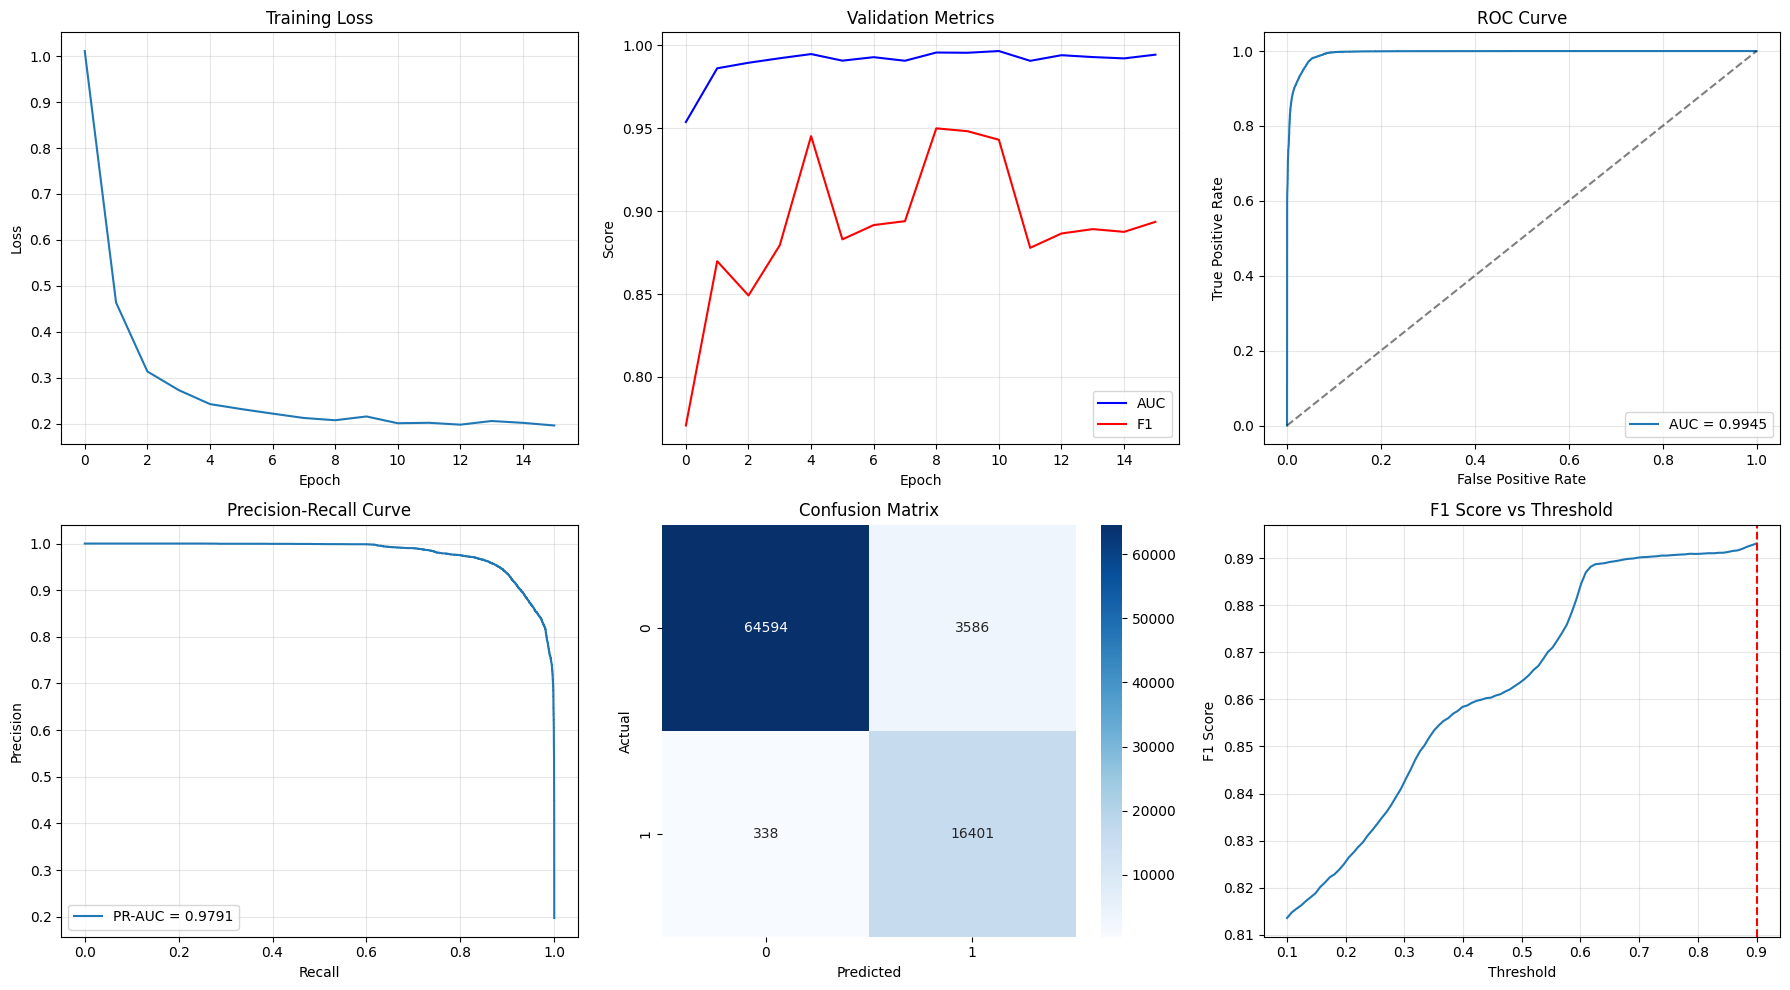


=== Performance Comparison ===
Original LSTM - AUC: 0.9915, F1: 0.8939
Advanced LSTM - AUC: 0.9945, F1: 0.8932
AUC Improvement: +0.0030
F1 Improvement: -0.0007


In [15]:
# ==============================
# Advanced LSTM Optimizations for CICIDS2017
# Based on excellent baseline results (AUC: 0.9915)
# ==============================

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report
)
import optuna
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==============================
# 1. Advanced LSTM Architecture
# ==============================
class AdvancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3, 
                 use_attention=True, bidirectional=True):
        super().__init__()
        
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Attention mechanism
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=4,
                dropout=dropout,
                batch_first=True
            )
        
        # Classification head with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        if self.use_attention:
            # Apply attention to all time steps
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # Use mean of attended outputs
            features = attended_out.mean(dim=1)
        else:
            # Use last time step
            features = lstm_out[:, -1, :]
        
        # Classification
        logits = self.classifier(features)
        
        return logits.squeeze(-1)

# ==============================
# 2. Advanced Training with Cross-Validation
# ==============================
def train_advanced_lstm(X_train, y_train, X_val, y_val, params, epochs=30):
    
    # Create weighted sampler for balanced training
    class_counts = Counter(y_train)
    class_weights = {0: 1.0, 1: class_counts[0] / class_counts[1]}
    sample_weights = [class_weights[int(label)] for label in y_train]
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    
    # Weighted sampler for balanced batches
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Initialize model
    model = AdvancedLSTM(
        input_dim=X_train.shape[2],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        use_attention=params.get('use_attention', True),
        bidirectional=params.get('bidirectional', True)
    ).to(device)
    
    # Advanced optimizer with weight decay
    if params.get('optimizer') == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=params.get('weight_decay', 1e-4)
        )
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=params['lr'] * 3,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3
    )
    
    # Loss function with class weights
    pos_weight = torch.FloatTensor([class_counts[0] / class_counts[1]]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Training metrics
    train_losses = []
    val_aucs = []
    val_f1s = []
    best_val_f1 = 0
    best_model_state = None
    patience = 7
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Add L2 regularization manually if needed
            if params.get('l2_reg', 0) > 0:
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += params['l2_reg'] * l2_norm
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        # Validation phase
        model.eval()
        val_probs = []
        val_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                val_probs.extend(probs)
                val_targets.extend(batch_y.numpy())
        
        val_probs = np.array(val_probs)
        val_targets = np.array(val_targets)
        
        # Calculate metrics
        val_auc = roc_auc_score(val_targets, val_probs)
        
        # Find best threshold for F1
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = [f1_score(val_targets, (val_probs >= t).astype(int)) for t in thresholds]
        best_f1 = max(f1_scores)
        
        val_aucs.append(val_auc)
        val_f1s.append(best_f1)
        
        # Early stopping based on F1 score
        if best_f1 > best_val_f1:
            best_val_f1 = best_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 5 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1:2d}/{epochs}: Loss={avg_loss:.4f}, "
                  f"Val AUC={val_auc:.4f}, Val F1={best_f1:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_aucs, val_f1s

# ==============================
# 3. Advanced Hyperparameter Optimization
# ==============================
def advanced_objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 5e-5, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'use_attention': trial.suggest_categorical('use_attention', [True, False]),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
        'l2_reg': trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True),
    }
    
    if params['optimizer'] == 'adamw':
        params['weight_decay'] = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    
    try:
        # Use cross-validation for more robust evaluation
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_seq, y_train_seq):
            X_cv_train, X_cv_val = X_train_seq[train_idx], X_train_seq[val_idx]
            y_cv_train, y_cv_val = y_train_seq[train_idx], y_train_seq[val_idx]
            
            model, _, _, val_f1s = train_advanced_lstm(
                X_cv_train, y_cv_train, X_cv_val, y_cv_val, 
                params, epochs=15
            )
            
            cv_scores.append(max(val_f1s))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0

# ==============================
# 4. Model Interpretability
# ==============================
def analyze_feature_importance(model, X_sample, feature_names):
    """Analyze which features are most important for predictions"""
    model.eval()
    
    # Use gradient-based feature importance
    X_tensor = torch.FloatTensor(X_sample[:100]).to(device)  # Use subset for speed
    X_tensor.requires_grad_(True)
    
    outputs = model(X_tensor)
    
    # Calculate gradients
    outputs.sum().backward()
    gradients = X_tensor.grad.abs().mean(dim=[0, 1]).cpu().numpy()
    
    # Create feature importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': gradients
    }).sort_values('importance', ascending=False)
    
    return importance_df

def plot_advanced_results(train_losses, val_aucs, val_f1s, test_results):
    """Create comprehensive result plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training history
    axes[0, 0].plot(train_losses)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(val_aucs, label='AUC', color='blue')
    axes[0, 1].plot(val_f1s, label='F1', color='red')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(test_results['y_true'], test_results['y_prob'])
    axes[0, 2].plot(fpr, tpr, label=f'AUC = {test_results["auc"]:.4f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(test_results['y_true'], test_results['y_prob'])
    axes[1, 0].plot(recall, precision, label=f'PR-AUC = {test_results["pr_auc"]:.4f}')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(test_results['y_true'], test_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    
    # Threshold analysis
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = [f1_score(test_results['y_true'], (test_results['y_prob'] >= t).astype(int)) 
                 for t in thresholds]
    axes[1, 2].plot(thresholds, f1_scores)
    axes[1, 2].axvline(x=test_results['best_threshold'], color='red', linestyle='--')
    axes[1, 2].set_title('F1 Score vs Threshold')
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==============================
# 5. Run Advanced Optimization
# ==============================
print("\n=== Advanced LSTM Optimization ===")

# Run hyperparameter optimization
print("Running advanced hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(advanced_objective, n_trials=25, timeout=7200)  # 2 hour timeout

print("Best hyperparameters:", study.best_params)
print("Best CV F1 score:", study.best_value)

# Train final model with best parameters
print("\nTraining final advanced model...")
best_params = study.best_params
final_model, train_losses, val_aucs, val_f1s = train_advanced_lstm(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, 
    best_params, epochs=40
)

# ==============================
# 6. Comprehensive Evaluation
# ==============================
print("\n=== Comprehensive Evaluation ===")

# Test evaluation
test_dataset = TensorDataset(torch.FloatTensor(X_test_seq), torch.FloatTensor(y_test_seq))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

final_model.eval()
test_probs = []
test_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = final_model(batch_X)
        probs = torch.sigmoid(outputs).cpu().numpy()
        
        test_probs.extend(probs)
        test_targets.extend(batch_y.numpy())

test_probs = np.array(test_probs)
test_targets = np.array(test_targets)

# Find optimal threshold
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(test_targets, (test_probs >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_final = (test_probs >= best_threshold).astype(int)

# Calculate all metrics
test_results = {
    'y_true': test_targets,
    'y_prob': test_probs,
    'y_pred': y_pred_final,
    'auc': roc_auc_score(test_targets, test_probs),
    'pr_auc': average_precision_score(test_targets, test_probs),
    'f1': f1_score(test_targets, y_pred_final),
    'precision': precision_score(test_targets, y_pred_final),
    'recall': recall_score(test_targets, y_pred_final),
    'best_threshold': best_threshold
}

print(f"Advanced Model Results:")
print(f"AUC: {test_results['auc']:.4f}")
print(f"PR-AUC: {test_results['pr_auc']:.4f}")
print(f"F1: {test_results['f1']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall: {test_results['recall']:.4f}")
print(f"Best Threshold: {test_results['best_threshold']:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(test_targets, y_pred_final, 
                          target_names=['Benign', 'Attack']))

# ==============================
# 7. Model Analysis
# ==============================
print("\n=== Model Analysis ===")

# Feature importance analysis
if len(numeric_cols) == X_test_seq.shape[2]:  # Make sure dimensions match
    importance_df = analyze_feature_importance(final_model, X_test_seq, numeric_cols)
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))

# Plot comprehensive results
plot_advanced_results(train_losses, val_aucs, val_f1s, test_results)

# Compare with original simple model
print(f"\n=== Performance Comparison ===")
print(f"Original LSTM - AUC: 0.9915, F1: 0.8939")
print(f"Advanced LSTM - AUC: {test_results['auc']:.4f}, F1: {test_results['f1']:.4f}")

improvement_auc = test_results['auc'] - 0.9915
improvement_f1 = test_results['f1'] - 0.8939
print(f"AUC Improvement: {improvement_auc:+.4f}")
print(f"F1 Improvement: {improvement_f1:+.4f}")